In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # disable GPU, use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#------------------------------------------------------------------------------------------
# import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
#------------------------------------------------------------------------------------------
from   qiskit                     import QuantumRegister, ClassicalRegister, transpile  # QuantumCircuit,
from   qiskit.circuit             import Parameter, ParameterVector, QuantumCircuit
from   qiskit.circuit.library     import RGQFTMultiplier, CU1Gate
from   qiskit.primitives          import Sampler, Estimator  # .sampler
try:
    from   qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_distribution
except:
    from   qiskit.visualization   import circuit_drawer, plot_histogram, plot_distribution
import qiskit.quantum_info        as qi
#------------------------------------------------------------------------------------------
import qiskit
from   qiskit_aer                 import AerSimulator
#------------------------------------------------------------------------------------------
from   threading import Thread
import matplotlib.pyplot          as plt
from   IPython.display            import display
from   statistics                 import mean
from   datetime                   import date, datetime
from   time                       import sleep, time, monotonic
import math
import cmath
import warnings
import pandas                     as pd
import numpy                      as np
np.set_printoptions(precision=6,threshold=np.inf,linewidth=np.inf,suppress=True)
# np.set_printoptions()
#------------------------------------------------------------------------------------------
try:
    warnings.filterwarnings("ignore")
    %matplotlib inline
except Exception as err:
    print(err)
#------------------------------------------------------------------------------------------

In [2]:
# try:
#     print( tf.test.is_built_with_cuda())
#     print( tf.config.list_physical_devices('GPU') )
#     print( tf.config.list_logical_devices() )
# except Exception as err:
#     print( err )

In [2]:
def QuantumSwapTest( test:float , memories:list , shots ):
    N = 8
    _testvector         = Parameter( "test" )
    _fingerprints       = ParameterVector( "fingerprints" , N )
    #---------------------------------------------------------------------------------------------------------
    Ancilla             = QuantumRegister(   1, 'Ancilla'     )
    TestVector          = QuantumRegister(   1, 'TestVector'  )
    FingerPrint         = QuantumRegister(   1, 'FingerPrint' )
    Address             = QuantumRegister(   3, 'Address'     )
    Routes              = QuantumRegister(   N, 'Routes'      )
    Memory              = QuantumRegister(   N, 'Memory'      )
    Tiles               = ClassicalRegister( N, 'Tiles'       )
    circuit             = QuantumCircuit( Ancilla , TestVector , FingerPrint , Address , Routes , Memory , Tiles )
    #---------------------------------------------------------------------------------------------------------
    # circuit.u( testvector_radians , 0, 0, TestVector  ) 
    circuit.h( Address[0] )
    circuit.h( Address[1] )
    circuit.h( Address[2] )
    #---------------------------------------------------------------------------------------------------------
    circuit.barrier() 
    #---------------------------------------------------------------------------------------------------------
    # qRAM algorithm starts
    #---------------------------------------------------------------------------------------------------------
    # Implements routing logic
    circuit.x(    Routes[0] )
    circuit.cx(  Address[2] , Routes[1] )
    circuit.cx(   Routes[1] , Routes[0] )
    circuit.ccx( Address[1] , Routes[0] , Routes[2] )
    circuit.cx(   Routes[2] , Routes[0] )
    circuit.ccx( Address[1] , Routes[1] , Routes[3] )
    circuit.cx(   Routes[3] , Routes[1] )
    circuit.ccx( Address[0] , Routes[0] , Routes[4] )
    circuit.cx(   Routes[4] , Routes[0] )
    circuit.ccx( Address[0] , Routes[1] , Routes[5] )
    circuit.cx(   Routes[5] , Routes[1] )
    circuit.ccx( Address[0] , Routes[2] , Routes[6] )
    circuit.cx(   Routes[6] , Routes[2] )
    circuit.ccx( Address[0] , Routes[3] , Routes[7] )
    circuit.cx(   Routes[7] , Routes[3] )
    #---------------------------------------------------------------------------------------------------------
    circuit.barrier()
    #---------------------------------------------------------------------------------------------------------
    circuit.u( _testvector , 0, 0, TestVector ) 
    for i in range(N):
        circuit.cu( _fingerprints[i] , 0, 0, 0, Routes[i] , FingerPrint )    
    #---------------------------------------------------------------------------------------------------------
    # qRAM algorithm ends
    #---------------------------------------------------------------------------------------------------------
    circuit.barrier()
    circuit.h(       Ancilla                            )
    circuit.cswap(   Ancilla , TestVector , FingerPrint )
    circuit.h(       Ancilla                            )
    circuit.barrier()
    circuit.x(       Ancilla                            )
    #---------------------------------------------------------------------------------------------------------
    for i in range(N):
        circuit.ccx( Ancilla , Routes[i], Memory[i] )
    circuit.barrier()
    #---------------------------------------------------------------------------------------------------------
    circuit.measure( Memory , Tiles )
    #---------------------------------------------------------------------------------------------------------
    circuit.barrier()
    circuit = circuit.reverse_bits()
     #----------------------------------------------------------------------------------------------------------
    try:
        circuit.assign_parameters( { 
                                    _testvector : test        
                                   } , inplace=True )
        for i in range(N):
            circuit.assign_parameters( { 
                                        _fingerprints[i] : memories[i] ,
                                       } , inplace=True )
    except Exception as err:
        print( "error" , err)
    #----------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------
    max_probability_address = 0
    try:
        address_mapping = {
                            '10000000' : 'Q1',
                            '01000000' : 'Q2',
                            '00100000' : 'Q3',
                            '00010000' : 'Q4',
                            '00001000' : 'Q5',
                            '00000100' : 'Q6',
                            '00000010' : 'Q7',
                            '00000001' : 'Q8',
                          }
        aer = AerSimulator()
        compiled_circuit = transpile( circuit , aer )
        job = aer.run( compiled_circuit , shots=shots ).result()  # 88888 100000 50000000
        counts = job.get_counts(0)
        sum = 0
        binary_sum = 0
        binary_probabilities = {}
        binary_frequencies   = {}
        bins = []
        max_probability_value   = 0
        for i in range(N):
            _address = int(math.pow( 2 , i ))
            _address = "{:08b}".format( _address )
            bins.append(_address)
            sum += counts[_address]
        counts['00000000'] = 0
        for i in range(N):
            _address  = int(math.pow( 2 , i ))
            _address  = "{:08b}".format( _address )
            _address2 = address_mapping[ _address ]
            probability = counts[_address] / sum
            if probability > max_probability_value:
                max_probability_value   = probability
                max_probability_address = _address2
            binary_probabilities[ _address2 ] = probability
            binary_frequencies[ _address2 ]   = counts[_address]
            binary_sum += probability
    except Exception as err:
        print( "error" , err)

    #----------------------------------------------------------------------------------------------------------
    return ( max_probability_address , binary_probabilities , binary_frequencies )

In [3]:
fingerprints = pd.read_csv( './Data/fingerprint_vectors.csv' , header='infer' )
fingerprints = list( fingerprints["radians"] )

testvectors = pd.read_csv( './Data/test_vectors.csv' , header='infer' )
testvectors = testvectors.loc[ : , [ "Region" , "radians" ] ]

In [4]:
def QuantumTestTrials( results , probabilities, frequencies , test_vector , fingerprints , shots ):

    try:
        predicted_region , binary_probabilities , binary_frequencies = QuantumSwapTest( test_vector , fingerprints, shots )

        for result in binary_probabilities:
            probabilities[result] = binary_probabilities[result]

        for result in binary_frequencies:
            frequencies[result] = binary_frequencies[result]

        if predicted_region in results:
            results[ predicted_region ] += 1
        else:
            results[ predicted_region ]  = 1
            
    except Exception as e:
        print(e)

In [5]:
def get_confusion_matrix( shots ):
    _confusion_matrix = None

    for i in range( testvectors.shape[0] ):
        try:
            row = testvectors.iloc[ i ]
            actual_region = row["Region"]
            test_vector   = float( row["radians"] )

            n_trials    = 30 # 200
            thread_list = []
            results              = {}
            binary_probabilities = {}
            binary_frequencies   = {}

            _start     = monotonic()
            _startTime = datetime.now().strftime("%H:%M:%S.%f") # %d-%B-%Y 
            for i in range( n_trials ):
                try:
                    _t = Thread( target = QuantumTestTrials , args=( results , binary_probabilities , binary_frequencies , test_vector , fingerprints , shots, ) )
                    _t.daemon = True
                    thread_list.append( _t )
                except Exception as e:
                    print(e)

            for i in range( n_trials ):
                try:
                    thread_list[i].start()
                except Exception as e:
                    print(e)

            for i in range( n_trials ):
                try:
                    thread_list[i].join( timeout = None )
                except Exception as e:
                    print(e)
            _endTime = datetime.now().strftime("%H:%M:%S.%f") # %d-%B-%Y 
            _end     = monotonic()

            # if shots > 50000000:
            #     print("\n-------------------------------------------------------------------------------------------")
            #     print( "Test Vector {} radians : ".format( round( test_vector , 5 ) ) , "Actual = " , actual_region , " Predicted = ", max( results , key=results.get ) )
            #     print("Started at ", _startTime, ", ended at ", _endTime, ", total elapsed ", round((_end-_start),1), " seconds")
            #     results = dict( sorted( results.items() ) )
            #     print( results )

            _table = None
            for i in range(1,9):
                _key = "Q{}".format(i)
                if _key in results:
                    _row = pd.DataFrame( [[actual_region,_key,results[_key]]] , columns=["Actual","Predicted","Count"] )
                    if _table is None:
                        _table = _row
                    else:
                        _table = pd.concat( [_table, _row] , axis=0 )
            _table = _table.reset_index( drop=True )

            if _confusion_matrix is None:
                _confusion_matrix = _table
            else:
                _confusion_matrix = pd.concat( [_confusion_matrix, _table] , axis=0 )

            # if shots > 50000000:
            #     display(_table)
            #     chart = plot_distribution( binary_probabilities ) # , sort='value_desc'
            #     display( chart )
            #     print("============================================================================================")

        except Exception as e:
            print(e)

    _confusion_matrix.reset_index( drop=True )
    return _confusion_matrix

In [7]:
shots     = 3200
accuracies = {}
for i in range(1,16):
    try:
        _confusion_matrix = get_confusion_matrix( shots )
        _confusion_matrix = _confusion_matrix.pivot_table( index='Predicted' , columns='Actual', values='Count' , fill_value=0 )
        _confusion_matrix.loc['Total'] = _confusion_matrix[ ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"] ].sum()
        accuracy = (_confusion_matrix.iloc[0,0] + _confusion_matrix.iloc[1,1] + _confusion_matrix.iloc[2,2] + _confusion_matrix.iloc[3,3] + 
                    _confusion_matrix.iloc[4,4] + _confusion_matrix.iloc[5,5] + _confusion_matrix.iloc[6,6] + _confusion_matrix.iloc[7,7] ) / 240
        print("Confusion Matrix for shots = {} , accuracy = {}".format(shots , accuracy))
        accuracies[shots] = accuracy
        _confusion_matrix.to_csv( "ConfusionMatrix_Shots_{}.csv".format(shots) , index=False, header=True )
        display( _confusion_matrix )

        shots *= 2
    except Exception as err:
        print(err)

Confusion Matrix for shots = 3200 , accuracy = 0.42083333333333334


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,5.0,9.0,0.0,0.0,0.0,5.0,7.0,1.0
Q2,6.0,4.0,0.0,0.0,0.0,2.0,4.0,7.0
Q3,0.0,0.0,21.0,1.0,2.0,0.0,0.0,0.0
Q4,0.0,0.0,4.0,11.0,12.0,1.0,0.0,0.0
Q5,0.0,0.0,5.0,18.0,16.0,0.0,0.0,0.0
Q6,7.0,8.0,0.0,0.0,0.0,13.0,7.0,1.0
Q7,11.0,8.0,0.0,0.0,0.0,9.0,11.0,1.0
Q8,1.0,1.0,0.0,0.0,0.0,0.0,1.0,20.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 6400 , accuracy = 0.4625


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,8.0,7.0,0.0,0.0,0.0,8.0,14.0,1.0
Q2,7.0,9.0,0.0,0.0,0.0,0.0,6.0,7.0
Q3,0.0,0.0,24.0,1.0,2.0,0.0,0.0,0.0
Q4,0.0,0.0,1.0,16.0,9.0,0.0,0.0,0.0
Q5,0.0,0.0,5.0,13.0,19.0,0.0,0.0,0.0
Q6,8.0,4.0,0.0,0.0,0.0,12.0,7.0,1.0
Q7,7.0,9.0,0.0,0.0,0.0,10.0,3.0,1.0
Q8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 12800 , accuracy = 0.5125


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,7.0,5.0,0.0,0.0,0.0,7.0,10.0,1.0
Q2,9.0,9.0,0.0,0.0,0.0,0.0,5.0,7.0
Q3,0.0,0.0,29.0,0.0,1.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,16.0,11.0,0.0,0.0,0.0
Q5,0.0,0.0,1.0,14.0,18.0,0.0,0.0,0.0
Q6,5.0,7.0,0.0,0.0,0.0,15.0,8.0,0.0
Q7,9.0,8.0,0.0,0.0,0.0,8.0,7.0,0.0
Q8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,22.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 25600 , accuracy = 0.5708333333333333


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,10.0,14.0,0.0,0.0,0.0,8.0,9.0,0.0
Q2,7.0,7.0,0.0,0.0,0.0,0.0,5.0,2.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,18.0,11.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,12.0,19.0,0.0,0.0,0.0
Q6,1.0,3.0,0.0,0.0,0.0,17.0,8.0,0.0
Q7,12.0,6.0,0.0,0.0,0.0,5.0,8.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 51200 , accuracy = 0.6291666666666667


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,8.0,10.0,0.0,0.0,0.0,1.0,11.0,0.0
Q2,11.0,14.0,0.0,0.0,0.0,0.0,3.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,17.0,14.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,13.0,16.0,0.0,0.0,0.0
Q6,2.0,0.0,0.0,0.0,0.0,23.0,3.0,0.0
Q7,9.0,6.0,0.0,0.0,0.0,6.0,13.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 102400 , accuracy = 0.6666666666666666


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,9.0,7.0,0.0,0.0,0.0,0.0,10.0,0.0
Q2,7.0,16.0,0.0,0.0,0.0,0.0,2.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,17.0,12.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,13.0,18.0,0.0,0.0,0.0
Q6,1.0,1.0,0.0,0.0,0.0,27.0,5.0,0.0
Q7,13.0,6.0,0.0,0.0,0.0,3.0,13.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 204800 , accuracy = 0.7083333333333334


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,14.0,12.0,0.0,0.0,0.0,0.0,8.0,0.0
Q2,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,22.0,7.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,8.0,23.0,0.0,0.0,0.0
Q6,1.0,0.0,0.0,0.0,0.0,30.0,7.0,0.0
Q7,8.0,12.0,0.0,0.0,0.0,0.0,15.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 409600 , accuracy = 0.7333333333333333


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,15.0,11.0,0.0,0.0,0.0,0.0,8.0,0.0
Q2,5.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,20.0,6.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,10.0,24.0,0.0,0.0,0.0
Q6,0.0,0.0,0.0,0.0,0.0,30.0,7.0,0.0
Q7,10.0,7.0,0.0,0.0,0.0,0.0,15.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 819200 , accuracy = 0.6791666666666667


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,12.0,10.0,0.0,0.0,0.0,0.0,13.0,0.0
Q2,4.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,16.0,12.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,14.0,18.0,0.0,0.0,0.0
Q6,0.0,0.0,0.0,0.0,0.0,30.0,4.0,0.0
Q7,14.0,6.0,0.0,0.0,0.0,0.0,13.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 1638400 , accuracy = 0.7875


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,12.0,5.0,0.0,0.0,0.0,0.0,11.0,0.0
Q2,5.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,21.0,3.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,9.0,27.0,0.0,0.0,0.0
Q6,0.0,0.0,0.0,0.0,0.0,30.0,2.0,0.0
Q7,13.0,3.0,0.0,0.0,0.0,0.0,17.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 3276800 , accuracy = 0.8083333333333333


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,21.0,11.0,0.0,0.0,0.0,0.0,8.0,0.0
Q2,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,18.0,1.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,12.0,29.0,0.0,0.0,0.0
Q6,0.0,0.0,0.0,0.0,0.0,30.0,3.0,0.0
Q7,9.0,2.0,0.0,0.0,0.0,0.0,19.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 6553600 , accuracy = 0.8958333333333334


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,23.0,2.0,0.0,0.0,0.0,0.0,9.0,0.0
Q2,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,5.0,30.0,0.0,0.0,0.0
Q6,0.0,0.0,0.0,0.0,0.0,30.0,1.0,0.0
Q7,7.0,1.0,0.0,0.0,0.0,0.0,20.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 13107200 , accuracy = 0.8916666666666667


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,24.0,6.0,0.0,0.0,0.0,0.0,8.0,0.0
Q2,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,6.0,30.0,0.0,0.0,0.0
Q6,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0
Q7,6.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


In [6]:
shots     = 26214400
accuracies = {}
for i in range(14,16):
    try:
        _confusion_matrix = get_confusion_matrix( shots )
        _confusion_matrix = _confusion_matrix.pivot_table( index='Predicted' , columns='Actual', values='Count' , fill_value=0 )
        _confusion_matrix.loc['Total'] = _confusion_matrix[ ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"] ].sum()
        accuracy = (_confusion_matrix.iloc[0,0] + _confusion_matrix.iloc[1,1] + _confusion_matrix.iloc[2,2] + _confusion_matrix.iloc[3,3] + 
                    _confusion_matrix.iloc[4,4] + _confusion_matrix.iloc[5,5] + _confusion_matrix.iloc[6,6] + _confusion_matrix.iloc[7,7] ) / 240
        print("Confusion Matrix for shots = {} , accuracy = {}".format(shots , accuracy))
        accuracies[shots] = accuracy
        _confusion_matrix.to_csv( "ConfusionMatrix_Shots_{}.csv".format(shots) , index=False, header=True )
        display( _confusion_matrix )

        shots *= 2
    except Exception as err:
        print(err)

Confusion Matrix for shots = 26214400 , accuracy = 0.9083333333333333


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,25.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0
Q2,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,7.0,30.0,0.0,0.0,0.0
Q6,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0
Q7,5.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


Confusion Matrix for shots = 52428800 , accuracy = 0.9833333333333333


Actual,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
Predicted,,,,,,,,
Q1,28.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Q2,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
Q5,0.0,0.0,0.0,1.0,30.0,0.0,0.0,0.0
Q6,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0
Q7,2.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0
Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
Total,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


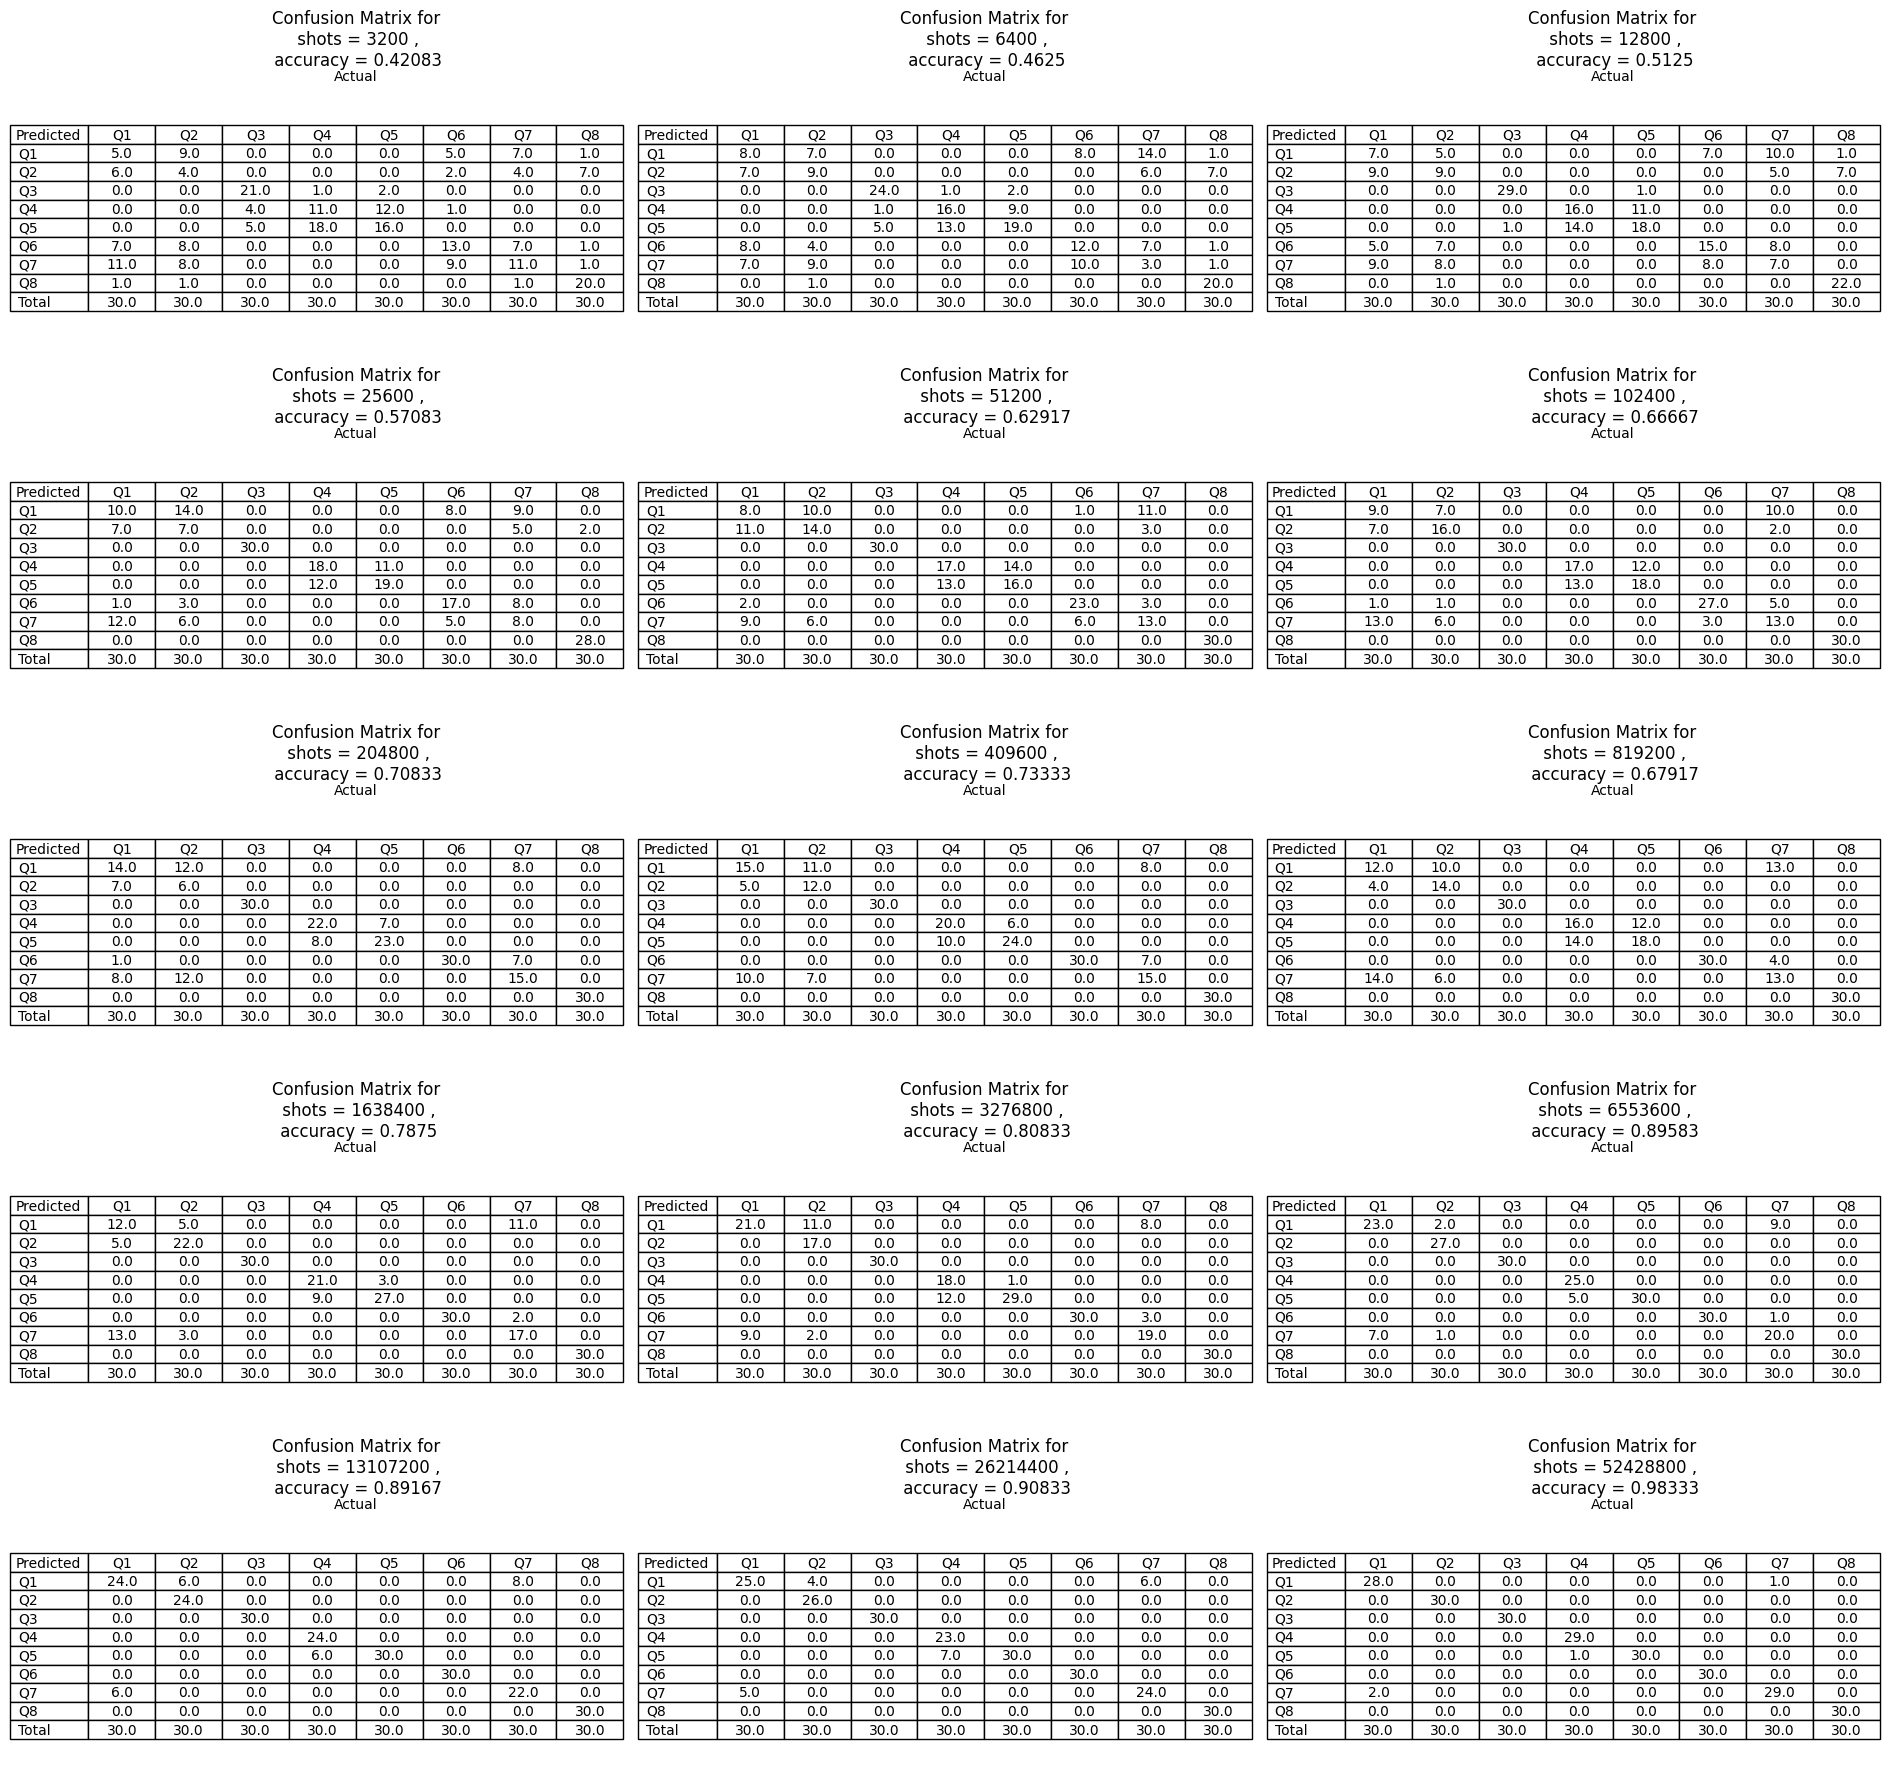

In [54]:
shots     = 3200

fix, ax = plt.subplots( 5, 3 , figsize=(19,18) )

for i in range(15):  # 52,428,800
    try:
        filepath = "ConfusionMatrix_Shots_{}.csv".format( shots )
        _confusion_matrix = pd.read_csv( filepath , header="infer" )
        _confusion_matrix = _confusion_matrix.rename(index={0: 'Q1',1: 'Q2',2: 'Q3',3: 'Q4',4: 'Q5',5: 'Q6',6: 'Q7',7: 'Q8',8: 'Total'})
        _confusion_matrix.index.name = 'Predicted'
        # _confusion_matrix['Predicted'] = _confusion_matrix.index
        # _confusion_matrix = _confusion_matrix.reset_index( drop=True )
        
        accuracy = (_confusion_matrix.iloc[0,0] + _confusion_matrix.iloc[1,1] + _confusion_matrix.iloc[2,2] + _confusion_matrix.iloc[3,3] + 
                    _confusion_matrix.iloc[4,4] + _confusion_matrix.iloc[5,5] + _confusion_matrix.iloc[6,6] + _confusion_matrix.iloc[7,7] ) / 240
        
        title = "Confusion Matrix for\n shots = {} ,\n accuracy = {}".format(shots , round(accuracy,5) )
        _row  = i // 3
        _col  = i % 3
        
        table = pd.plotting.table( ax[_row][_col], _confusion_matrix, loc='center', cellLoc='center' )
        # ax[_row][_col].axis('off')

        ax[_row][_col].xaxis.tick_top()
        ax[_row][_col].xaxis.set_label_position('top')
        ax[_row][_col].set_xlabel('Actual')
        ax[_row][_col].set_title(title, pad=-14)
        ax[_row][_col].set_frame_on(False)
        ax[_row][_col].set_xticks([])
        ax[_row][_col].set_yticks([])

        w, h = table[0,1].get_width(), table[0,1].get_height()
        table.add_cell(0, -1, w,h, text=_confusion_matrix.index.name)
        
        shots *= 2

    except Exception as err:
        print(err)

plt.margins( 0.0, tight=True) 
plt.tight_layout()

plt.savefig( "ConfusionMatrix.jpg" )
plt.show()

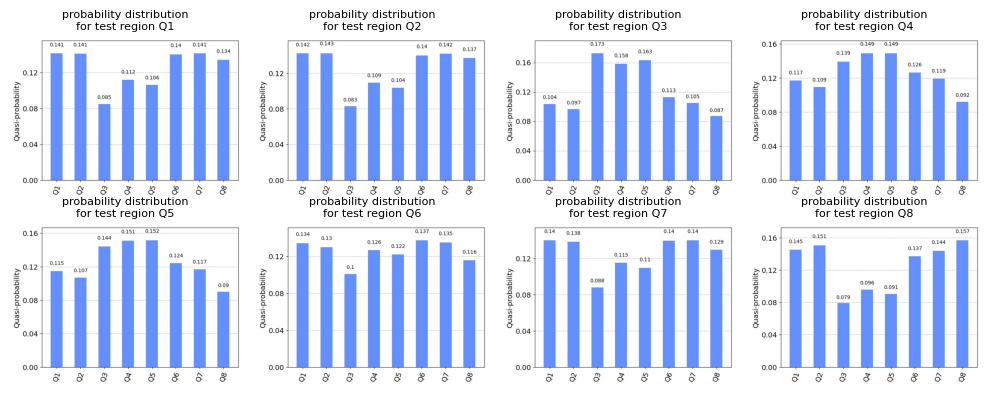

In [17]:
fix, ax = plt.subplots( 2, 4 , figsize=(10,4) )

for i in range(8):
    try:
        _row  = i // 4
        _col  = i % 4
        _file = "TestVectorQ{}.jpg".format(i+1)
        image = plt.imread(_file)
        ax[_row][_col].imshow(image)
        ax[_row][_col].axis('off')
        ax[_row][_col].set_title("probability distribution\nfor test region Q{}".format(i+1), fontsize = 8 )
        
    except Exception as err:
        print(err)
        
plt.tight_layout()
plt.savefig( "ProbabilityDistribution.jpg" )
plt.show()